# Algorithmic trading with Keras (using LSTM and 1-dim Convolution)

We use Long Short Time Memory recurrent neural networks and 1-dimensional convolutions to develop two trading strategies for the S&P 500 index: in both cases the first trading day of each month we want our model to tell us if we are going to stay in the market for the current month or not.

We verify that, in a period of 4 years which comprehends the 2008 crisis, these deep learning trading strategies performed far better than the buy and hold strategy (stay always in the market) and the moving average strategy (buy when the current price is greater or equal to the moving average of past 12 months and sell otherwise). 

We compute the gross and net yield (as it is by the Italian law: 26% tax on capital gain and 0.10% fee to the broker at each transaction): our models performed respectively a 10.5% and a 11.5% net annual yield (which is not bad, considering the 2008 crisis)

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance
from scipy.optimize import brute

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Part 1: Get the data 

We use Yahoo Finance to get the data of the S&P 500 index. Our analysis is monthly-based, and all the decisions are made the first trading day of the month. For this reason, we fix the conventin that *start_date* will always be the first day of a month and *end_date* will always be the last day of a month.

For a reason which will be clarified by the following code, our analysis will start from 24 months after the month of *start_date* and end the month before the month of *end_date*

In [2]:
start_date=datetime.datetime(1973, 1, 1)
end_date=datetime.datetime(2011,3,31)

In [3]:
df = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
df.drop("Adj Close",axis=1,inplace=True)
print(df.tail())

                   High          Low         Open        Close      Volume
Date                                                                      
2011-03-25  1319.180054  1310.150024  1311.800049  1313.800049  4223740000
2011-03-28  1319.739990  1310.189941  1315.449951  1310.189941  3215170000
2011-03-29  1319.449951  1305.260010  1309.369995  1319.439941  3482580000
2011-03-30  1331.739990  1321.890015  1321.890015  1328.260010  3809570000
2011-03-31  1329.770020  1325.030029  1327.439941  1325.829956  3566270000


We need the list of the first trading day for each month

In [4]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

In order to develop our trading strategy, we need to obtain a dataframe with the monthly means and the first trading day of the month price. 

For each month we need the means of the month, the first trading day of the current month (and its open price) and the first trading day of the next month (and its open price).

The feature *rapp* is the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month. It will be used because it gives the variation of the portfolio for the current month

Finally we add the columns corresponding to the moving averages at 1 and 2 years

In [5]:
def monthly_df(df):

    dfm=df.resample("M").mean()
    dfm=dfm[:-1] # As we said, we do not consider the month of end_date
    
    dfm["fd_cm"]=first_days[:-1]
    dfm["fd_nm"]=first_days[1:]
    dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
    dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
    dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])
    
    dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
    dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)
    
    dfm=dfm.iloc[24:,:] # we remove the first 24 months, since they do not have the 2-year moving average
    
    return dfm

In [6]:
dfm=monthly_df(df)

print(dfm.head())
print(dfm.tail())

#each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)
print(dfm.loc["1980-03","mv_avg_12"])
print(dfm.loc["1979-03":"1980-02","Open"])
print(dfm.loc["1979-03":"1980-02","Open"].mean())

                 High        Low       Open      Close        Volume  \
Date                                                                   
1975-01-31  73.546817  71.442273  72.240455  72.564091  1.966136e+07   
1975-02-28  80.988421  78.892106  79.838947  80.096842  2.229684e+07   
1975-03-31  84.783500  82.723500  83.698499  83.831999  2.268050e+07   
1975-04-30  85.649999  83.705001  84.544091  84.723182  2.051591e+07   
1975-05-31  91.089047  89.058096  89.921905  90.096190  2.178524e+07   

                fd_cm      fd_nm  fd_cm_open  fd_nm_open      rapp  mv_avg_12  \
Date                                                                            
1975-01-31 1975-01-02 1975-02-03   68.650002   76.980003  1.121340  82.952279   
1975-02-28 1975-02-03 1975-03-03   76.980003   81.589996  1.059886  80.960840   
1975-03-31 1975-03-03 1975-04-01   81.589996   83.360001  1.021694  79.826673   
1975-04-30 1975-04-01 1975-05-01   83.360001   87.300003  1.047265  78.672500   
1975-05-3

Finally, we can divide *dfm* in train and test set

In [7]:
mtest=72
train=dfm.iloc[:-mtest,:] 
test=dfm.iloc[-mtest:,:] 

## Part 2: Define functions to compute gross and net yield

Notice that the gross yield can be computed very easily using the feature *rapp*.
The following function explains how: the vector v selects which months we are going to stay in the market

In [8]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

We just need to define a function to compute the net yield, considering (as it is by the Italian law) a 26% tax on capital gain and 0.10% commission to the broker at each transaction

In [9]:
tax_cg=0.26
comm_bk=0.001

In [10]:
# This function will be used in the function yield_net

# Given any vector v of ones and zeros, this function gives the corresponding vectors of "islands" of ones of v
# and their number. 
# For example, given v = [0,1,1,0,1,0,1], expand_islands2D gives
# out2D = [[0,1,1,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]] and N=3

def expand_islands2D(v):
    
    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array  of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

Again, the vector v selects which months we are going to stay in the market

In [11]:
# This function returns the total percentage net yield and the annual percentage net yield

def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)  # A is the product of each island of ones of 1 for df["rapp"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   

## Part 3: Define the two models: "LSTM" and "Mix"

We want to use LSTM neural network and 1-dim convolutions to decide, the first day of each day of the test period, whether we are going to stay in the market for the month or not.

We reshape the data and at each step we want to predict the opening price of the first day of the next month: in this way we will be able to find the vector v which selects the months during which we are going to stay in the market.

We create two models: one (called model_lstm) which is made of LSTM recurrent neural networks and one (called model_mix) composed of LSTM and 1-dimensional convolutional layers

In [12]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [13]:
def data_to_model(dfm):
    scaler=MinMaxScaler(feature_range=(0,1))
    dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
    X=dg[[0,1,2,3,4,5,6,7]]
    X=create_window(X,window)
    X=np.reshape(X.values,(X.shape[0],window+1,8))
    
    y=np.array(dg[8][window:])
    
    return X,y

In [14]:
window=5

X,y=data_to_model(dfm)
print X.shape,y.shape

(429, 6, 8) (429,)


In [15]:
X_train=X[:-mtest-1,:,:]
X_test=X[-mtest-1:,:,:]
y_train=y[:-mtest-1]
y_test=y[-mtest-1:]

In [16]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False)) # there is no need to specify input_shape here
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

In [17]:
def model_mix(window,features):
    
    model=Sequential()
    model.add(Conv1D(input_shape=(window,features),filters=32,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(Conv1D(filters=64,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(LSTM(300, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

In [18]:
model_lstm=model_lstm(window+1,8)
print model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 300)            370800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 791,801
Trainable params: 791,801
Non-trainable params: 0
_________________________________________________________________
None

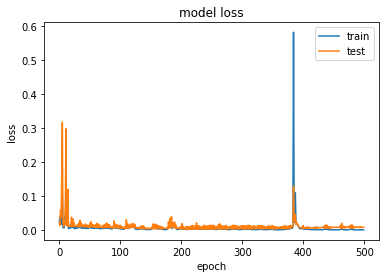

In [19]:
history_lstm=model_lstm.fit(X_train,y_train,epochs=500, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=0, callbacks=[],shuffle=False)

plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
mod

In [20]:
model_mix=model_mix(window+1,8)
print model_mix.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 32)             544       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 64)             4160      
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 300)            438000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
__________

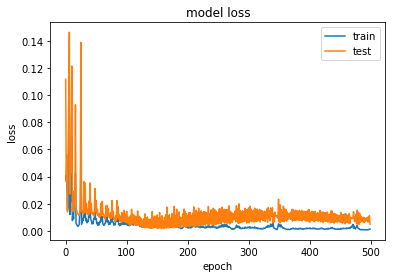

In [21]:
history_mix=model_mix.fit(X_train,y_train,epochs=500, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=0, callbacks=[],shuffle=False)

plt.plot(history_mix.history['loss'])
plt.plot(history_mix.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [31]:
model_mix.save_weights("mix_weights.h5")

In [22]:
y_pred_train_lstm=model_lstm.predict(X_train)
y_pred_train_mix=model_mix.predict(X_train)

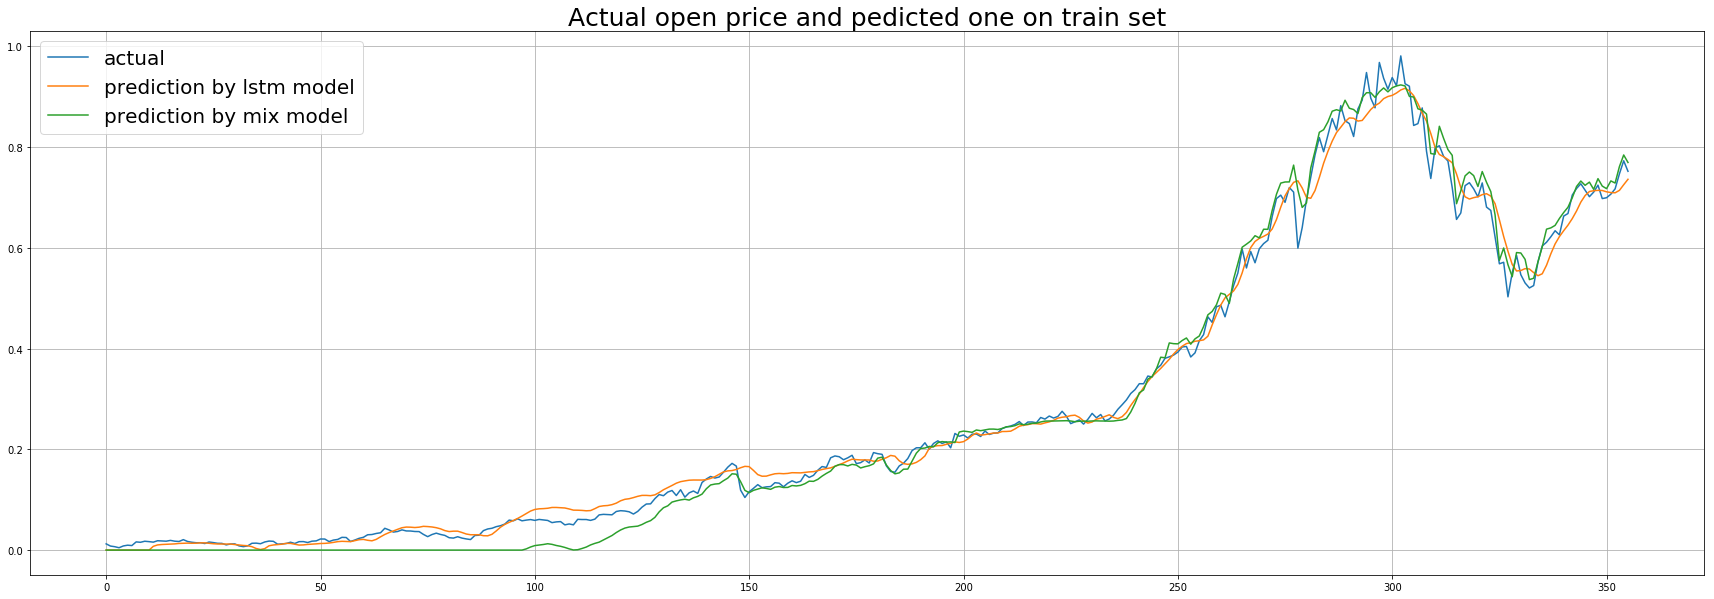

In [23]:
plt.figure(figsize=(30,10))
plt.plot(y_train, label="actual")
plt.plot(y_pred_train_lstm, label="prediction by lstm model")
plt.plot(y_pred_train_mix, label="prediction by mix model")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [24]:
y_pred_lstm=model_lstm.predict(X_test)
y_pred_mix=model_mix.predict(X_test)

**We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vectors v indicate the "in months" (as 1s) and "out months" (as 0s)**

In [25]:
w_lstm=np.diff(y_pred_lstm.reshape(y_pred_lstm.shape[0]),1)
v_lstm=np.maximum(np.sign(w_lstm),0)

w_mix=np.diff(y_pred_mix.reshape(y_pred_mix.shape[0]),1)
v_mix=np.maximum(np.sign(w_mix),0)

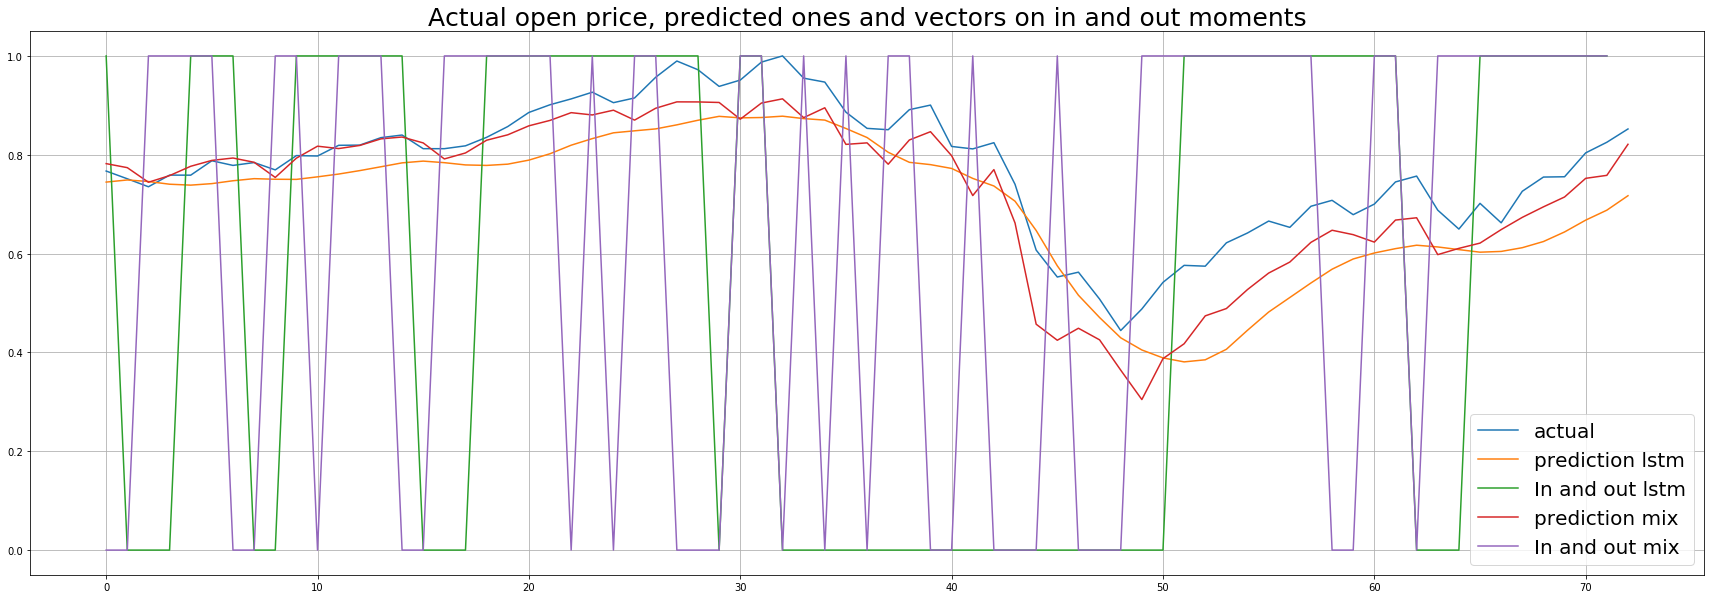

In [26]:
plt.figure(figsize=(30,10))
plt.plot(y_test, label="actual")
plt.plot(y_pred_lstm, label="prediction lstm")
plt.plot(v_lstm,label="In and out lstm")
plt.plot(y_pred_mix, label="prediction mix")
plt.plot(v_mix,label="In and out mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted ones and vectors on in and out moments",fontsize=25)
plt.show()

**The preceeding plot shows an interesting feature of the prediction of our models: they are quite good at predicting the sign of the first derivative of the index, and this is exactly what we need for our trading strategy!** 

## Part 4: Compare the LSTM model and Mix model with other methods

Now we can compare our deep learning trading strategies with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the months during which we are going to stay in the market.

In [27]:
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [28]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

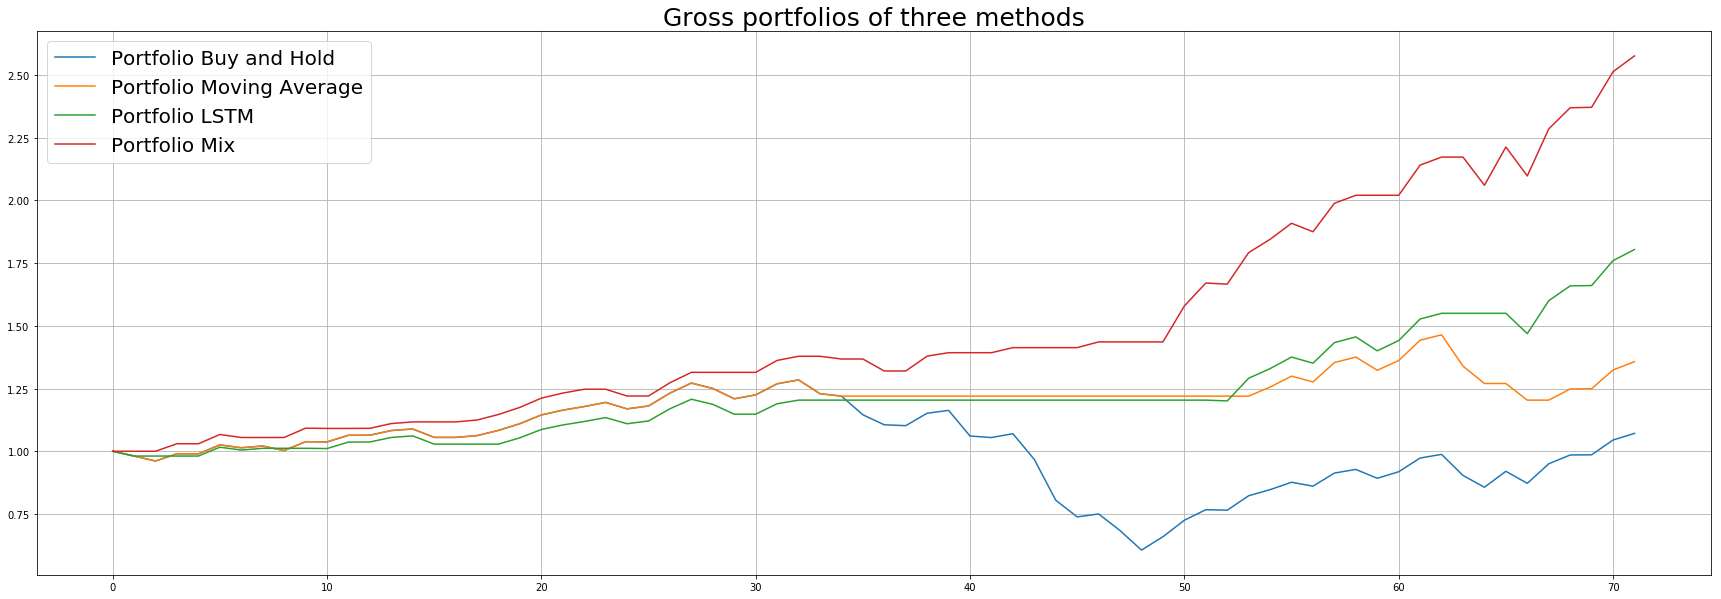

In [29]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.plot(gross_portfolio(test,v_mix),label="Portfolio Mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [30]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results=pd.DataFrame({})
results["Method"]=["Buy and hold","Moving average","LSTM","Mix"]

vs=[v_bh,v_ma,v_lstm,v_mix]
results["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results)

Test period of 6.00 years, from 2005-03-01 to 2011-03-01 

           Method Total gross yield Annual gross yield Total net yield  \
0    Buy and hold           10.39 %             1.66 %          7.47 %   
1  Moving average           39.86 %             5.75 %         26.14 %   
2            LSTM            85.9 %            10.89 %         56.87 %   
3             Mix          165.43 %            17.67 %         99.94 %   

  Annual net yield  
0           1.21 %  
1           3.95 %  
2           7.79 %  
3          12.24 %  
